# Data Wrangling and EDA

__Dataset information__

&nbsp;&nbsp;&nbsp;&nbsp; The train dataset comprises 6,334 chest scans in DICOM format, which were de-identified to protect patient privacy. All images were labeled by a panel of experienced radiologists for the presence of opacities as well as overall appearance.

&nbsp;&nbsp;&nbsp;&nbsp; All images are stored in paths with the form study/series/image. The study ID here relates directly to the study-level predictions, and the image ID is the ID used for image-level predictions.

&nbsp;&nbsp;&nbsp;&nbsp; The hidden test dataset is of roughly the same scale as the training dataset.

__Files__
* train_study_level.csv - the train study-level metadata, with one row for each study, including correct labels.
* train_image_level.csv - the train image-level metadata, with one row for each image, including both correct labels and any bounding boxes in a dictionary format. Some images in both test and train have multiple bounding boxes.
* sample_submission.csv - a sample submission file containing all image- and study-level IDs.

__Columns__

*train_study_level.csv*
* id - unique study identifier
* Negative for Pneumonia - 1 if the study is negative for pneumonia, 0 otherwise
* Typical Appearance - 1 if the study has this appearance, 0 otherwise
* Indeterminate Appearance  - 1 if the study has this appearance, 0 otherwise
* Atypical Appearance  - 1 if the study has this appearance, 0 otherwise


*train_image_level.csv*
* id - unique image identifier
* boxes - bounding boxes in easily-readable dictionary format
* label - the correct prediction label for the provided bounding boxes

# Imports and Helper Function

In [90]:
!pip install git+https://github.com/pydicom/pydicom-data

  Cloning https://github.com/pydicom/pydicom-data to /tmp/pip-req-build-48zunv9e
  Running command git clone -q https://github.com/pydicom/pydicom-data /tmp/pip-req-build-48zunv9e


In [91]:
import pandas as pd
import numpy as np
import ast
import os

import matplotlib.pyplot as plt
from pydicom import dcmread
import random
from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [92]:
def plot_image(num_rows,num_cols,df, with_label=False, show_name=False):
    
    nrows = num_rows
    ncols = num_cols

    if len(df)<=nrows*ncols:
        images = [df.iloc[i,:] for i in range(len(df))]
    else:
        images = [df.iloc[i,:] for i in random.sample(range(0, len(df)), nrows*ncols)]
    
    # Set up matplotlib fig, and size it to fit 4x4 pics
    fig = plt.gcf()
    fig.set_size_inches(ncols*4, nrows*4)

    for i, item in enumerate(images):
        # Set up subplot; subplot indices start at 1
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off') # Don't show axes (or gridlines)

        ds = dcmread(item.image_path)
        plt.imshow(ds.pixel_array)
        
        if with_label and item.boxes!=0:
            for i in item.boxes:
                rect = patches.Rectangle((i['x'], i['y']), 
                                          i['width'], i['height'], 
                                          linewidth=1, 
                                          edgecolor='r', 
                                          facecolor='none')
                # Add the patch to the Axes
                sp.add_patch(rect)
        if show_name:
            plt.title(item.class_name)
    plt.show()

# Data Loading and Information

__Three Parts:__

* train_image_level.csv information
* train_study_level.csv information
* Image file information and study id and iamge id in the image file

## train_image_level.csv information

In [93]:
image_level_path = '../input/siim-covid19-detection/train_image_level.csv'

image_level_df = pd.read_csv(image_level_path)
image_level_df.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


In [94]:
image_level_df.shape

(6334, 4)

In [95]:
image_level_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6334 entries, 0 to 6333
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                6334 non-null   object
 1   boxes             4294 non-null   object
 2   label             6334 non-null   object
 3   StudyInstanceUID  6334 non-null   object
dtypes: object(4)
memory usage: 198.1+ KB


### Check the null values

In [96]:
image_level_df.isnull().sum()

id                     0
boxes               2040
label                  0
StudyInstanceUID       0
dtype: int64

In [97]:
label = np.array([])
labels = image_level_df['label']
for i in range(len(labels)):
    info = labels[i].split()
    label = np.append(label, info[0])

In [98]:
image_level_df[label=='none'].isnull().sum()

id                     0
boxes               2040
label                  0
StudyInstanceUID       0
dtype: int64

* All entires with missing value in columns 'boxes' are corresponding to the non-label entries in column 'label', so there are total 2040 images without label.

### Check whether the number of boxes is the same as the number of labels for each observation 

In [99]:
labeled_df = image_level_df[label !='none']
boxes = list(labeled_df.boxes)
labels = list(labeled_df.label)
is_match = []
for b,l in zip(boxes, labels):
    box = ast.literal_eval(b)
    l_split = l.split()
    is_match.append(len(box)==len(l_split)/6)
    
print('The number of boxes and the number of labels for each observation match?')
print(sum(is_match)==len(is_match))

The number of boxes and the number of labels for each observation match?
True


 * The number of boxes is the same as the number of labeks for each observation.

## train_study_level.csv information

In [100]:
study_level_path = '../input/siim-covid19-detection/train_study_level.csv'
study_level_df = pd.read_csv(study_level_path)
study_level_df.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


In [101]:
study_level_df.shape

(6054, 5)

In [102]:
study_level_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6054 entries, 0 to 6053
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        6054 non-null   object
 1   Negative for Pneumonia    6054 non-null   int64 
 2   Typical Appearance        6054 non-null   int64 
 3   Indeterminate Appearance  6054 non-null   int64 
 4   Atypical Appearance       6054 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 236.6+ KB


In [103]:
study_level_df.isnull().sum()

id                          0
Negative for Pneumonia      0
Typical Appearance          0
Indeterminate Appearance    0
Atypical Appearance         0
dtype: int64

## Image file information and study id and iamge id in the image file

In [104]:
train_image_path = '../input/siim-covid19-detection/train'
dataset = os.listdir(train_image_path)
print("Total number of image:", len(dataset))

Total number of image: 6054


In [105]:
image_path=[]
for dirname, _, filenames in os.walk('../input/siim-covid19-detection/train'):
    for filename in filenames:
        image_path.append(os.path.join(dirname, filename))

In [106]:
# Create a data frame with columns of image path, study level id, and iamge level id from the image path
image_df = pd.DataFrame({'image_path':image_path})
ids = image_df['image_path'].str.replace('../input/siim-covid19-detection/train/','').str.split('/')
ids_df = pd.DataFrame(ids)
ids_df = pd.DataFrame(ids_df.pop('image_path').values.tolist())
image_df['study_id'] = ids_df.iloc[:,0]+'_study'
image_df['image_id'] = ids_df.iloc[:,2].str.replace('.dcm', '_image')
image_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


,image_path,study_id,image_id
0,../input/siim-covid19-detection/train/cd5dd5e6...,cd5dd5e6f3f5_study,d8ba599611e5_image
1,../input/siim-covid19-detection/train/49358afc...,49358afcfb80_study,29b23a11d1e4_image
2,../input/siim-covid19-detection/train/e4b50e74...,e4b50e7402c3_study,8174f49500a5_image
3,../input/siim-covid19-detection/train/e4b50e74...,e4b50e7402c3_study,d54f6204b044_image
4,../input/siim-covid19-detection/train/92aad2d0...,92aad2d01be8_study,d51cadde8626_image


In [107]:
# Number of study level id
len(study_level_df.id.unique())

6054

In [108]:
sum(study_level_df.id.isin(image_df.study_id))

6054

* All id in train_study_level.csv are in the study id of image set

In [109]:
# Number of image level id
len(image_level_df.id.unique())

6334

In [110]:
sum(image_level_df.id.isin(image_df.image_id))

6334

* All image ID in the image set match all the id in train_image_level.csv

### Plot Some Image Randomly

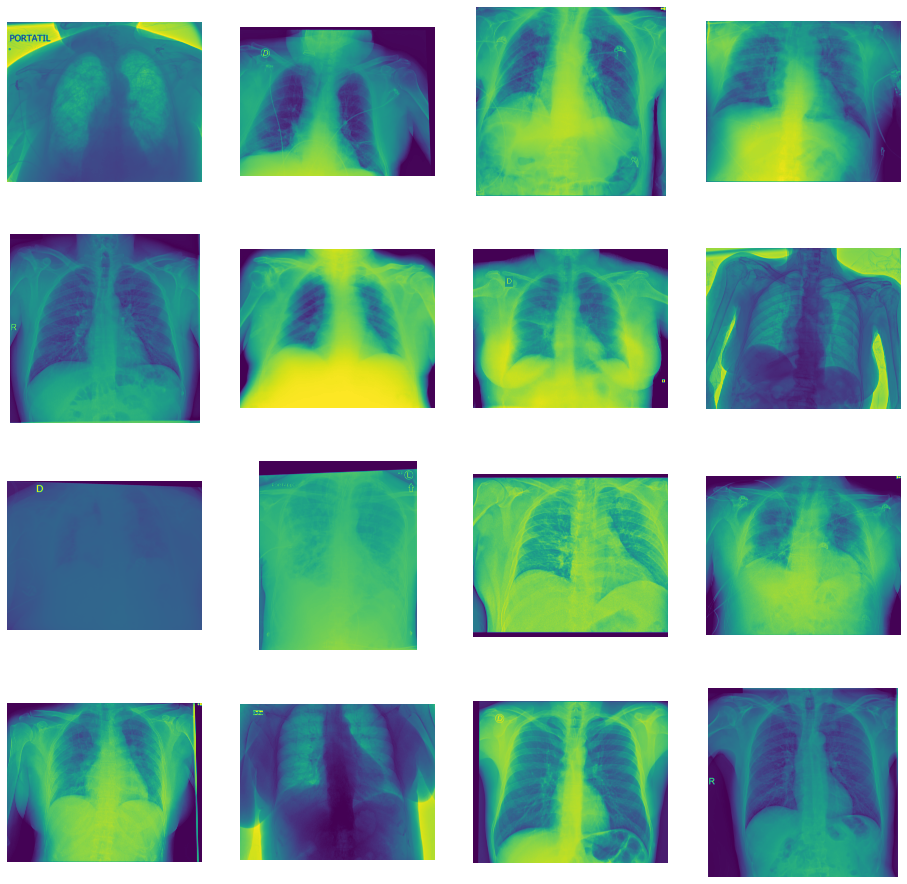

In [113]:
plot_image(4,4,image_df)

# Exploratory Data Analysis

* Combine the dataframes
* Distribution of diagnosed Class
* Image Level vs Study Level
* Image Level Study and Number of Labels of the images
* Diagnosed calsses vs the number of boxes of classes
* Plot the images

## Combine the dataframes

In [114]:
combined_df = image_level_df.merge(image_df, how='left',left_on='id', right_on='image_id')
combined_df.drop('id', axis=1, inplace=True)

combined_df = combined_df.merge(study_level_df,how='left', left_on='study_id', right_on='id')
combined_df.drop('id',axis=1,inplace=True)

combined_df.shape

(6334, 10)

In [115]:
combined_df.head()

,boxes,label,StudyInstanceUID,image_path,study_id,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,../input/siim-covid19-detection/train/5776db0c...,5776db0cec75_study,000a312787f2_image,0,1,0,0
1,NaN,none 1 0 0 1 1,ff0879eb20ed,../input/siim-covid19-detection/train/ff0879eb...,ff0879eb20ed_study,000c3a3f293f_image,1,0,0,0
2,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,../input/siim-covid19-detection/train/9d514ce4...,9d514ce429a7_study,0012ff7358bc_image,0,1,0,0
3,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,../input/siim-covid19-detection/train/28dddc85...,28dddc8559b2_study,001398f4ff4f_image,0,0,0,1
4,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,../input/siim-covid19-detection/train/dfd9fdd8...,dfd9fdd85a3e_study,001bd15d1891_image,0,1,0,0


In [116]:
combined_df.isnull().sum()

boxes                       2040
label                          0
StudyInstanceUID               0
image_path                     0
study_id                       0
image_id                       0
Negative for Pneumonia         0
Typical Appearance             0
Indeterminate Appearance       0
Atypical Appearance            0
dtype: int64

## Distribution of diagnosed Class: Negative for Pneumonia, Typical Appearance, Indeterminate Appearance, Atypical Appearance

In [300]:
diagnosed_class = ['Negative for Pneumonia','Typical Appearance','Indeterminate Appearance','Atypical Appearance']
study_df = combined_df[diagnosed_class]

In [118]:
study_df.sum(axis=0).sum()

6334

* One observation is corresponding to one class

### Distribution of the Four Classes for the Whole Data Set

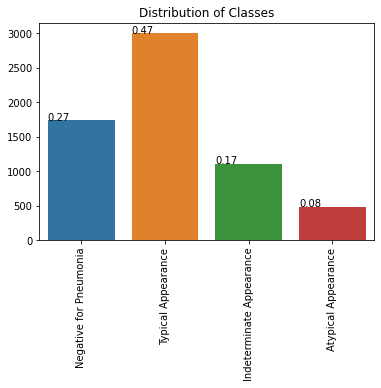

In [119]:
class_counts = study_df.sum(axis=0)
ax = sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks(rotation=90)
plt.title('Distribution of Classes')

for p in ax.patches:
    txt = str((p.get_height()/sum(class_counts.values)).round(2))
    txt_x = p.get_x()
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)

* Class imbalance. Atypical Appearance has only 8%. Typical Appearance has 47%.

### Distribution of the Four Classes for the Observations with Labels

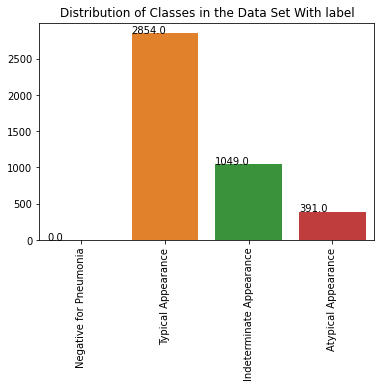

In [120]:
with_box = study_df[~combined_df.boxes.isnull()].sum(axis=0)

ax = sns.barplot(x=with_box.index, y=with_box.values)
plt.xticks(rotation=90)
plt.title('Distribution of Classes in the Data Set With label')

for p in ax.patches:
    txt = str((p.get_height()).round(2))
    txt_x = p.get_x()
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)

* The class 'Negative for Pneumonia' is not labeled, so no box for the observations. 

### Distribution of the Four Classes for the Observations without Labels

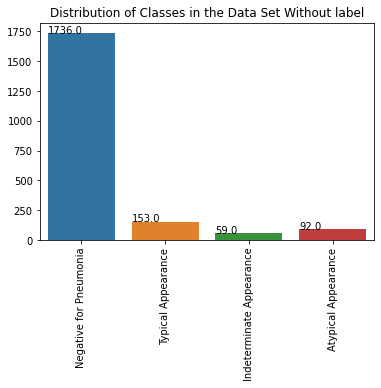

In [121]:
without_box = study_df[combined_df.boxes.isnull()].sum(axis=0)

ax = sns.barplot(x=without_box.index, y=without_box.values)
plt.xticks(rotation=90)
plt.title('Distribution of Classes in the Data Set Without label')

for p in ax.patches:
    txt = str((p.get_height()).round(2))
    txt_x = p.get_x()
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)

In [122]:
# Take a look at the observations that are not 'Negative for Pneumonia' but have no labeled
not_labeled_pos_Pneumonia_df = combined_df[combined_df.boxes.isnull()][combined_df['Negative for Pneumonia']==0]
not_labeled_pos_Pneumonia_df.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(304, 10)

In [123]:
not_labeled_pos_Pneumonia_df.label.unique()

array(['none 1 0 0 1 1'], dtype=object)

* Total 304 observations identified as classes of Typical Appearance, Indeterminate Appearance, Atypical Appearance are not labeled.

## Image level vs study level

* We have 6054 unique study level id and 6334 unique image level id, so exist some study-level predictions have more than 1 image level prediction.

In [124]:
study_image_df = combined_df[['study_id','image_id']]
image_count_df = study_image_df.groupby('study_id').count().reset_index()
image_count_df.columns = ['study_id','image_id_count']
image_count_df[image_count_df.image_id_count>1]

,study_id,image_id_count
16,00f9e183938e_study,2
24,0142feaef82f_study,2
76,0369e0385796_study,2
132,061d2ddaddd1_study,2
134,066b12d875eb_study,2
...,...,...
5928,fa9ea207e240_study,2
5935,fae06a05819a_study,2
5964,fc45007f145a_study,2
5996,fd92c6f2b2e6_study,2


* 232 study level predictions have more than one image level predictions.

In [125]:
s = image_count_df.image_id_count.value_counts()
for i in range(len(s)):
    print(s.values[i], 'of the study level predictions have', s.index[i], 'image level predictions.')

5822 of the study level predictions have 1 image level predictions.
207 of the study level predictions have 2 image level predictions.
15 of the study level predictions have 3 image level predictions.
4 of the study level predictions have 4 image level predictions.
3 of the study level predictions have 5 image level predictions.
1 of the study level predictions have 9 image level predictions.
1 of the study level predictions have 6 image level predictions.
1 of the study level predictions have 7 image level predictions.


In [126]:
image_count_df[image_count_df.image_id_count>1].image_id_count.sum()

512

* There 512 of the image level predictions share 232 study level ids, and the rest of 5822 image level predictions have their own unique study level id. 

## Image level study and number of labels of the images

In [127]:
# change the str type of the boxes column to list 
#and add a column 'num_box' with the number of boxes for each observation

str_to_list = [ast.literal_eval(box) if not pd.isna(box) else [] for box in combined_df.boxes]
combined_df['boxes'] = str_to_list
combined_df['num_boxes'] = [len(box) for box in combined_df.boxes]
combined_df.head()

,boxes,label,StudyInstanceUID,image_path,study_id,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,num_boxes
0,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,../input/siim-covid19-detection/train/5776db0c...,5776db0cec75_study,000a312787f2_image,0,1,0,0,2
1,[],none 1 0 0 1 1,ff0879eb20ed,../input/siim-covid19-detection/train/ff0879eb...,ff0879eb20ed_study,000c3a3f293f_image,1,0,0,0,0
2,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,../input/siim-covid19-detection/train/9d514ce4...,9d514ce429a7_study,0012ff7358bc_image,0,1,0,0,2
3,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,../input/siim-covid19-detection/train/28dddc85...,28dddc8559b2_study,001398f4ff4f_image,0,0,0,1,1
4,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,../input/siim-covid19-detection/train/dfd9fdd8...,dfd9fdd85a3e_study,001bd15d1891_image,0,1,0,0,2


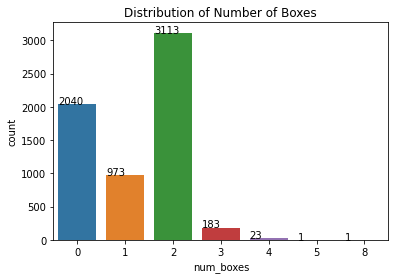

In [128]:
ax = sns.countplot(x='num_boxes', data=combined_df)
plt.title('Distribution of Number of Boxes')

for p in ax.patches:
    txt = str((p.get_height()).round(2))
    txt_x = p.get_x()
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)

## Diagnosed calsses vs the number of boxes of classes

In [129]:
# Add class name column to the dataframe comined_df
combined_df['class_name'] = study_df.idxmax(1)

In [130]:
df = combined_df.copy()
df['count'] = np.ones(6334)

pd.pivot_table(df, 
               values='count', 
               index=['num_boxes'],
               columns=['class_name'],
               aggfunc=np.sum)

class_name,Atypical Appearance,Indeterminate Appearance,Negative for Pneumonia,Typical Appearance
num_boxes,,,,
0,92.0,59.0,1736.0,153.0
1,261.0,685.0,NaN,27.0
2,115.0,345.0,NaN,2653.0
3,14.0,17.0,NaN,152.0
4,1.0,1.0,NaN,21.0
5,NaN,1.0,NaN,NaN
8,NaN,NaN,NaN,1.0


Text(0.5, 1.0, 'Distribution of Number of Boxes Classify By Diagnosed Calss')

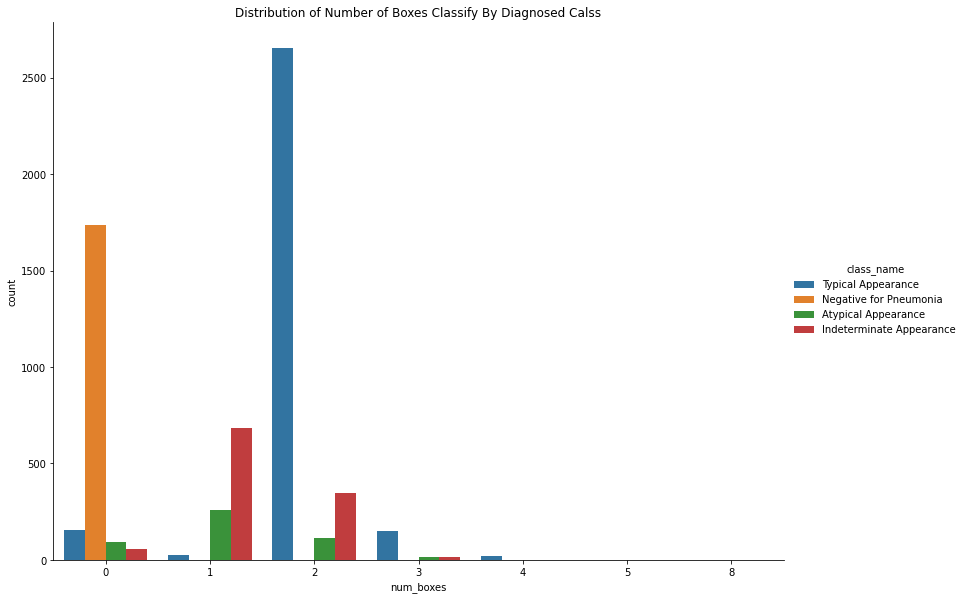

In [131]:
ax = sns.catplot(x='num_boxes', hue='class_name',kind='count', data=combined_df, height=8, aspect=11/8)

plt.title('Distribution of Number of Boxes Classify By Diagnosed Calss')

* Most of the non-negative Pneumonia observations have two labels.
* Most of observations with two labels are Typical Appearance.
* Most of observations with one label are Atypical and Indeterminate Appearance

## Plot the images

* Image of Negative for Pneumonia
* Image different number of boxes
* Plot the 7 images that share the same study level id


### Image of Negative for Pneumonia

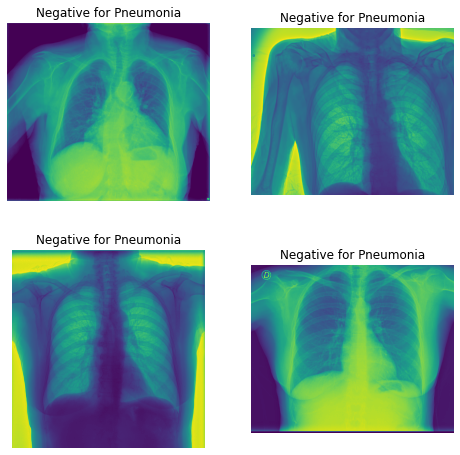

In [132]:
#Plot some images for Negative Pneumonia
df_negative = combined_df[combined_df['Negative for Pneumonia']==1].reset_index()
plot_image(2,2,df_negative,show_name=True)

## Image different number of boxes

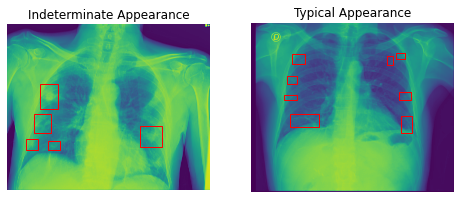

In [133]:
# Plot the Image with 5 and 8 Boxes
box_5and8_df = combined_df[combined_df.num_boxes>=5]
plot_image(1,2,box_5and8_df, with_label=True, show_name=True)

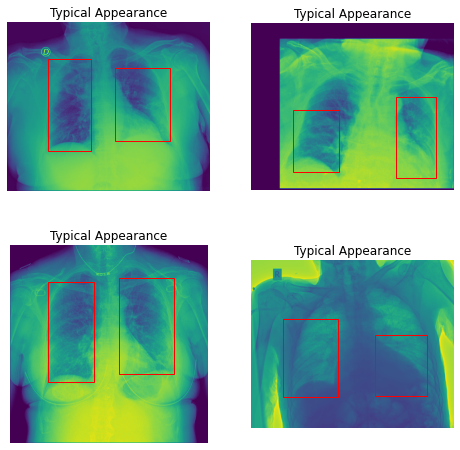

In [134]:
# Plot the Image with 2 Boxes randomly
box2_df = combined_df[combined_df.num_boxes==2]
plot_image(2,2,box2_df, with_label=True, show_name=True)

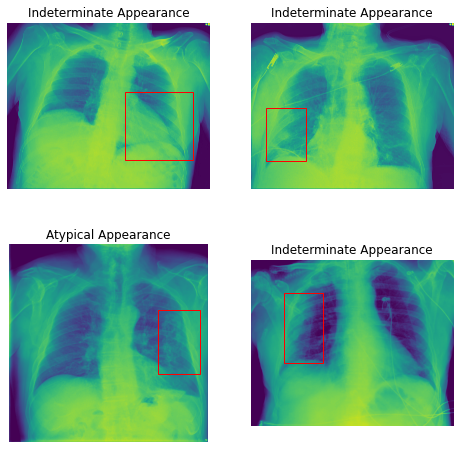

In [135]:
# Plot the Image with 1 Box randomly
box1_df = combined_df[combined_df.num_boxes==1]
plot_image(2,2,box1_df, with_label=True, show_name=True)

## Plot the images that share the same study level id

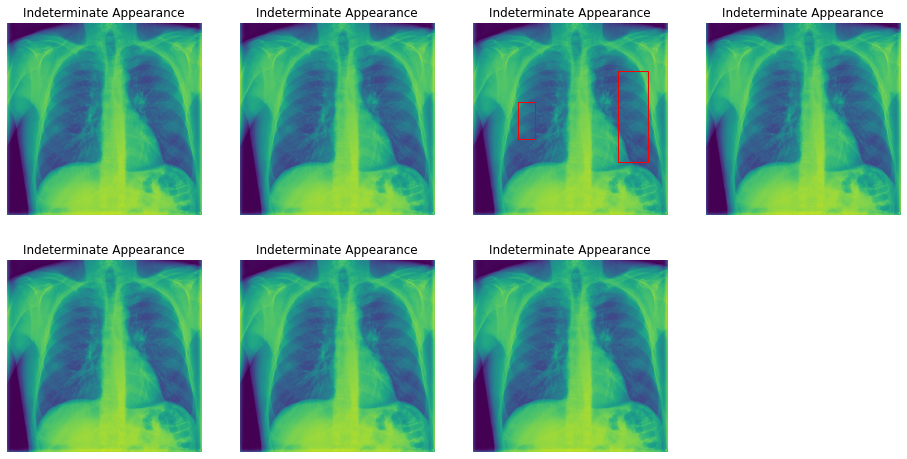

In [136]:
study_level_7image_df= combined_df[combined_df.study_id.isin(image_count_df[image_count_df.image_id_count==7].study_id)]
plot_image(2,4,study_level_7image_df, with_label=True, show_name=True)

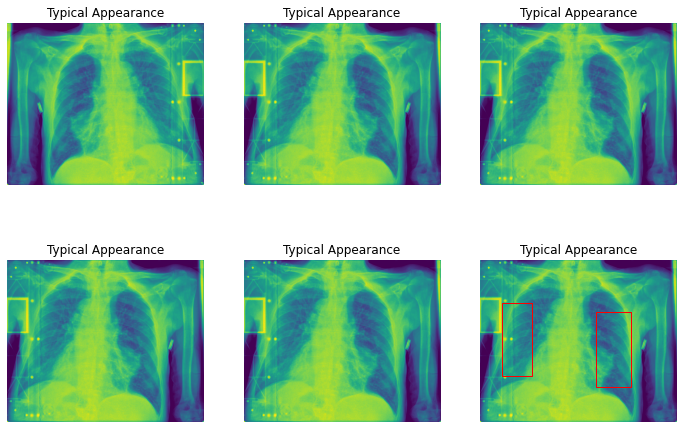

In [137]:
study_level_6image_df= combined_df[combined_df.study_id.isin(image_count_df[image_count_df.image_id_count==6].study_id)]
plot_image(2,3,study_level_6image_df, with_label=True, show_name=True)

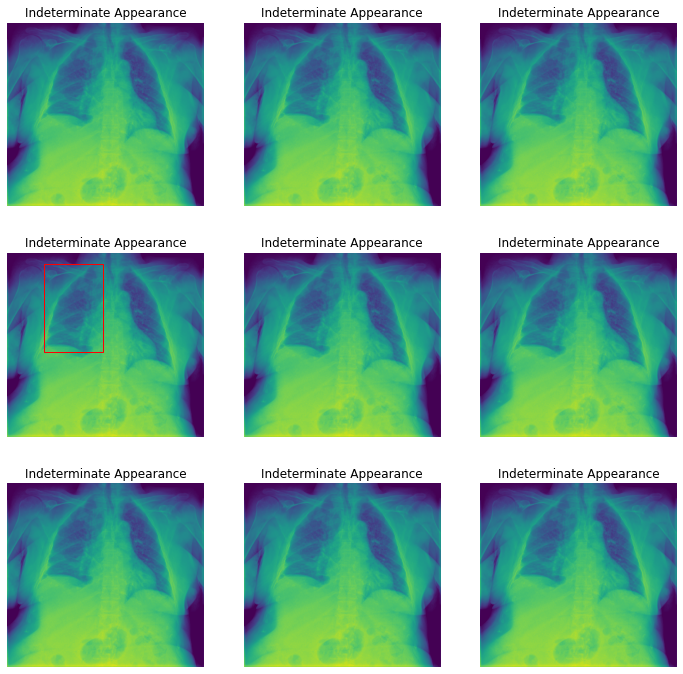

In [138]:
study_level_9image_df= combined_df[combined_df.study_id.isin(image_count_df[image_count_df.image_id_count==9].study_id)]
plot_image(3,3,study_level_9image_df, with_label=True, show_name=True)

* Looks like the same study level share the same image and the same diagnosed class, but only one of them has label. This mean that there exist duplicated images, we need to remove those image from the data set.

# Remove the rows of duplicated images from the date frame

In [225]:
duplicated_images_id = image_count_df[image_count_df.image_id_count>1].study_id
single_images_id = image_count_df[image_count_df.image_id_count==1].study_id
duplicated_images_df = combined_df[combined_df.study_id.isin(duplicated_images_id)]
Negative_df = duplicated_images_df[duplicated_images_df['Negative for Pneumonia']==1]
non_Negative_df = duplicated_images_df[duplicated_images_df['Negative for Pneumonia']!=1]

In [286]:
Negative_id = Negative_df.groupby('study_id').first().image_id
non_Negative_id = non_Negative_df.loc[non_Negative_df.groupby('study_id')['num_boxes'].idxmax()].image_id

In [287]:
# Remove all the duplicated images
df = combined_df[combined_df.study_id.isin(single_images_id)|combined_df.image_id.isin(Negative_id)|combined_df.image_id.isin(non_Negative_id)]
df.shape

(6054, 12)

In [288]:
len(df.image_id.unique())

6054

In [289]:
len(df.study_id.unique())

6054

* Now, we have the data set that one study level id is corresponding to only one image level id.

### Check whether the duplicated images were still exist in the data frame

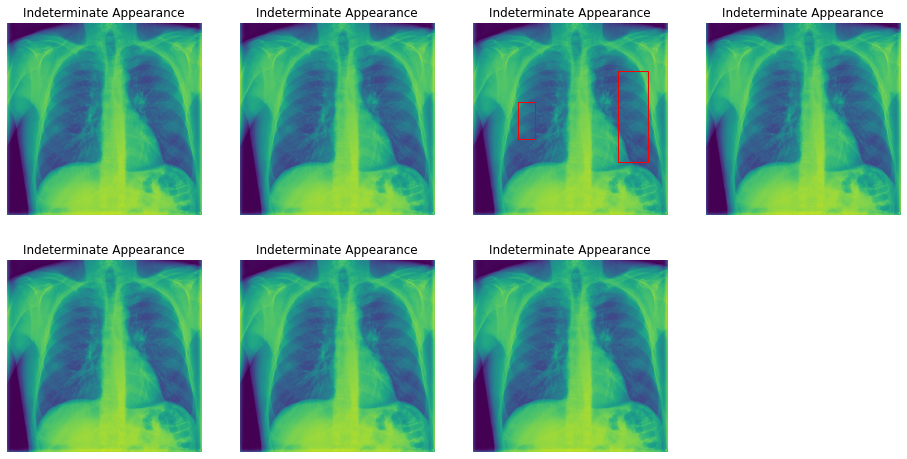

In [292]:
study_level_7image_df= combined_df[combined_df.study_id.isin(image_count_df[image_count_df.image_id_count==7].study_id)]
plot_image(2,4,study_level_7image_df, with_label=True, show_name=True)

* These are the images form the same study level prediction, it has 7 duplicated images from the original data set

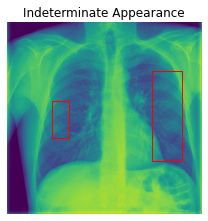

In [290]:
study_level_7image_df= df[df.study_id.isin(image_count_df[image_count_df.image_id_count==7].study_id)]
plot_image(2,4,study_level_7image_df, with_label=True, show_name=True)

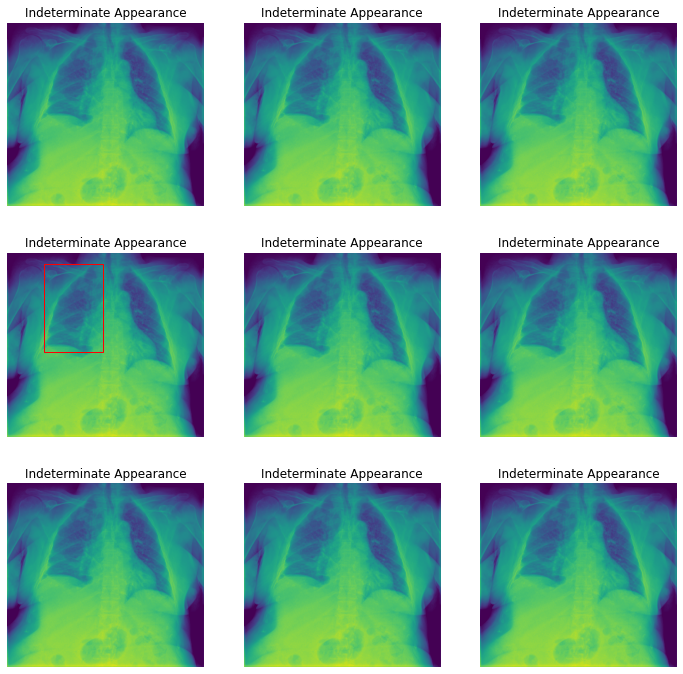

In [303]:
study_level_9image_df= combined_df[combined_df.study_id.isin(image_count_df[image_count_df.image_id_count==9].study_id)]
plot_image(3,3,study_level_9image_df, with_label=True, show_name=True)

* These are the images form the same study level prediction, it has 7 duplicated images from the original data set

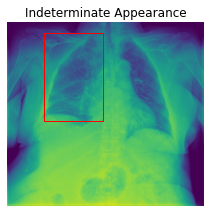

In [304]:
study_level_9image_df= df[df.study_id.isin(image_count_df[image_count_df.image_id_count==9].study_id)]
plot_image(3,3,study_level_9image_df, with_label=True, show_name=True)

* Now,for the same study level prediction, it has only one image left with the labels

In [299]:
df[(df['Negative for Pneumonia']==0)&(df.num_boxes==0)].shape

(84, 12)

* There are 84 observations that are not 'Negative for Pneumonia' without label. 

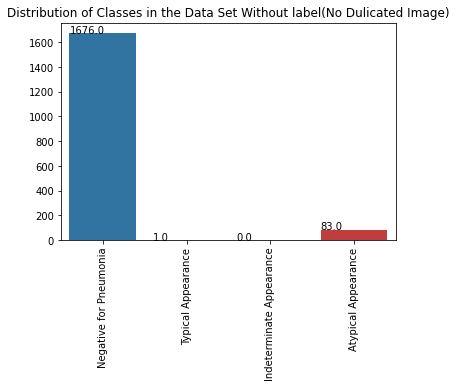

In [302]:
without_box = df[diagnosed_class][df.num_boxes == 0].sum(axis=0)

ax = sns.barplot(x=without_box.index, y=without_box.values)
plt.xticks(rotation=90)
plt.title('Distribution of Classes in the Data Set Without label(No Dulicated Image)')

for p in ax.patches:
    txt = str((p.get_height()).round(2))
    txt_x = p.get_x()
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)

# Save the cleaned data

In [298]:
df.to_csv('./data_information.csv')